In [1]:
%pylab inline

import pyart
import pandas as pd
import os
import datetime as dt
import seaborn as sns
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

import metpy.calc as mpcalc
from metpy.units import units

Populating the interactive namespace from numpy and matplotlib

## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/wradlib/io/radolan.py:835: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'RR': {'add_offset': np.float(0),
/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/wradlib/io/radolan.py:842: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'RA': {'add_offset': np.float(0),


### Read data

In [2]:
path_file = '/home/icrisologo/Data/'
fname_i = 'ERA5_innerlevels.nc'
fname_o = 'ERA5_outerlevels.nc'

In [3]:
ds_i = xr.open_dataset(os.path.join(path_file,fname_i))
ds_o = xr.open_dataset(os.path.join(path_file,fname_o))

In [4]:
ds_ = xr.concat([ds_i,ds_o],dim='level')

In [5]:
ds_.to_netcdf('ERA5_allevels.nc')

In [6]:
ds_sorted = ds_.sortby('level')

In [7]:
ds = ds_sorted.isel(expver = 1)

In [8]:
lat = ds['latitude'] # shape: (19,)
lon = ds['longitude'] # shape: (27,)
level = ds['level'] # shape: (12,)
dtime = ds['time'] # shape: (6912,)
temp = ds['t'] # shape: (6912, 12, 19, 27)

In [9]:
temp_col = temp[500,:,10,15] - 273.15

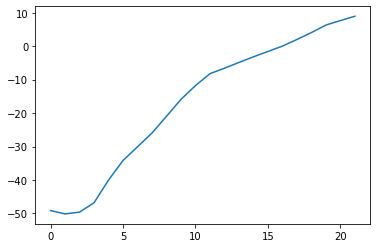

In [10]:
plt.plot(temp_col)

In [11]:
%%time

# testing for location [10,15] (in array indices)

temp_col_tseries = []
level_at_zero = []
for i in range(len(dtime)):
    temp_col = temp[i,:,10,15] - 273.15
    temp_col_tseries.append(temp_col.data)

# convert list to array
temp_col_tseries = np.array(temp_col_tseries)

CPU times: user 1min 47s, sys: 4.16 s, total: 1min 51s
Wall time: 1min 52s


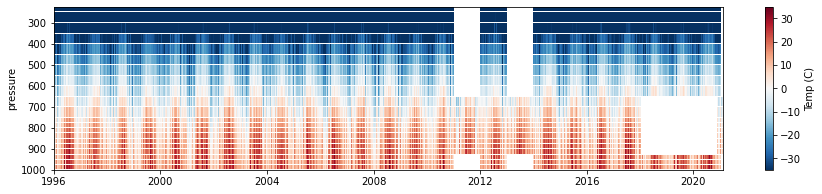

In [12]:
fig = plt.figure(figsize=(15,3))

ax1 = fig.add_subplot(111)
qmesh = plt.pcolormesh(dtime.data, level.data, temp_col_tseries.T, 
                       cmap='RdBu_r', vmin=-35, vmax=35)
ax1 = plt.gca()
cb = fig.colorbar(qmesh,ax=ax1)
cb.set_label('Temp (C)')

ax1.axis('tight')
ax1.set_ylabel('pressure')
# Set up as dates
ax1.xaxis_date()
plt.gca().invert_yaxis()

In [13]:
ds2017 = ds.sel(time=slice("2017-01-01", "2017-01-30"))

In [46]:
lat = ds['latitude'] # shape: (19,)
lon = ds['longitude'] # shape: (27,)
level = ds['level'] # shape: (12,)
dtime = ds['time'] # shape: (6912,)
temp = ds['t'] # shape: (6912, 12, 19, 27)

In [47]:
%%time
temp_col_tseries = []
level_at_ML = []
height_hydrostatic = []
for i in range(len(dtime)):
    temp_col = temp[i,:,10,15]
    
    level_ = level.data[np.where((temp_col.data<=3.0+273.15)&(temp_col.data>=1.0+273.15))]
    temp_ = temp_col.data[np.where((temp_col.data<=3.0+273.15)&(temp_col.data>=1.0+273.15))]

    if len(level_)==0:
        level_at_ML.append(np.nan)
        height_hydrostatic.append(np.nan)
    else:
        level_at_ML_ = [level[-1].data, np.nanmean(level_)] * units.hPa
        temp_at_ML_ = [temp_col[-1].data, np.nanmean(temp_)] * units.kelvin
        height_hydro_ = mpcalc.thickness_hydrostatic(pressure=level_at_ML_,temperature=temp_at_ML_)
        height_hydrostatic.append(height_hydro_)
    temp_col_tseries.append(temp_col.data)
    
temp_col_tseries = np.array(temp_col_tseries)

CPU times: user 3min 42s, sys: 8.45 s, total: 3min 51s
Wall time: 3min 50s


In [48]:
h_val = []
for h in height_hydrostatic:
    try:
        h_val.append(h.magnitude)
    except:
        h_val.append(np.nan)

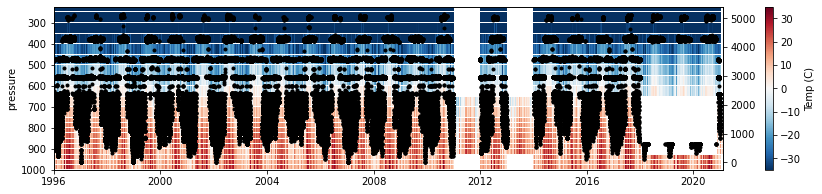

In [49]:
fig = plt.figure(figsize=(15,3))

ax1 = fig.add_subplot(111)
qmesh = plt.pcolormesh(dtime.data, level.data, temp_col_tseries.T - 273.15, 
                       cmap='RdBu_r', vmin=-35, vmax=35)
ax1 = plt.gca()
cb = fig.colorbar(qmesh,ax=ax1)
cb.set_label('Temp (C)')
#ax1.plot(dtime.data,level_at_zero,'ko',ms=3)
#ax1.plot(dtime.data,h_val,'ko',ms=3)
ax1.axis('tight')
ax1.set_ylabel('pressure')
# Set up as dates
ax1.xaxis_date()
plt.gca().invert_yaxis()


ax2=ax1.twinx()
ax2.plot(dtime.data,h_val,'ko',ms=3)
#ax2.set_ylim([0,5000])

#ax1.set_xlim(['2017-01-01','2017-01-30'])

In [50]:
 #my_data = np.array([dtime.data.T, h_val]).T

In [51]:
 my_data = np.array(h_val).T

In [52]:
df_ts = pd.DataFrame(my_data, index=dtime.data, columns = ['Height'])

In [53]:
df_ts.to_csv('ERA5_MeltingLayer_height.csv')

In [43]:
df_ts

,Height
2017-01-01 00:00:00,1326.223907
2017-01-01 01:00:00,1325.790419
2017-01-01 02:00:00,1446.705360
2017-01-01 03:00:00,1818.295269
2017-01-01 04:00:00,1817.658218
...,...
2017-01-30 19:00:00,NaN
2017-01-30 20:00:00,NaN
2017-01-30 21:00:00,NaN
2017-01-30 22:00:00,NaN
